## San Francisco Crime Classification  - 舊金山犯罪分類
- 從1934年到1963年，舊金山因高犯罪而臭名昭著。時至今日，舊金山雖以高科技著稱於世，但犯罪率扔高居不下。
- 目的：數據提供了近12年整個灣區的犯罪記錄，需要我們做的是預測犯罪的類型

## 評估
- Submissions are evaluated using the multi-class logarithmic loss. Each incident has been labeled with one true class.

## 特徵定義
- Dates -  犯罪事件的時間 
- Category - 犯罪事件類別（要預測的目標變量）
- Descript - 犯罪事件的詳細描述（只在訓練集上）不使用
- DayOfWeek - 星期幾
- PdDistrict - 出警的警局名稱
- Resolution - 犯罪事件是如何解決的（只在訓練集上）不使用
- Address - 犯罪事件的大致街道地址
- X - 經度
- Y - 緯度

In [446]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import LabelEncoder # 用於特徵提取, 將數值資料轉為離散
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, RandomForestClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import xgboost as xgb
import lightgbm as lgb
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

import datetime as dt
import string

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_row', 200) 
pd.set_option('display.max_columns', 100) 

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

In [447]:
# 載入訓練資料集
train = pd.read_csv('./data/San Francisco Crime Classification/train.csv')
train.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [448]:
# 載入測試資料集
test = pd.read_csv('./data/San Francisco Crime Classification/test.csv')
test.head(5)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


## 觀察資料
- 發現只有 X 與 Y 是數值
- 目標特徵: Category 是字串
- 透過 groupby().size() 確認一下各犯罪類型個數: 總共有39種犯罪類型
- 犯罪類型: 前五占了犯罪比的60%
    - LARCENY/THEFT   盜竊/盜竊
    - OTHER OFFENSES  其他罪行
    - NON-CRIMINAL    非刑事犯罪
    - ASSAULT         突擊
    - DRUG/NARCOTIC   藥物/麻醉
- 犯罪地區: 分析
    - southern 地區治安最差
    - Richmond 地區治安最好
- Dates : 犯罪事件時間分析
    - 年 => 2015年開始犯罪率驟降
    - 月 => 五月與十月犯罪率最高
    - 日 => 每個月的月初與月末有些微漲幅
- Day of week : 週期判斷
    - 半夜12點與晚上六點為案發高峰期, 凌晨數量少
    - 週五週六, 晚上八點後明顯犯案機率高

In [449]:
# 確認資料特徵類型
print(f'train_data dtypes:\n{train.dtypes}')
print(f'\ntrain_data shape: {train.shape}')
print(f'\ntest_features shape: {test.shape}')

train_data dtypes:
Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

train_data shape: (878049, 9)

test_features shape: (884262, 7)


#### 1. Category 犯罪類型

In [450]:
# 根據 Category 這個特徵 將不同的類別分為個別的群體
cate_group = train.groupby('Category').size() 

# 犯罪類型數量
cat_num = len(cate_group.index)
print("犯罪類型數量: " + str(cat_num))

cate_group

犯罪類型數量: 39


Category
ARSON                            1513
ASSAULT                         76876
BAD CHECKS                        406
BRIBERY                           289
BURGLARY                        36755
DISORDERLY CONDUCT               4320
DRIVING UNDER THE INFLUENCE      2268
DRUG/NARCOTIC                   53971
DRUNKENNESS                      4280
EMBEZZLEMENT                     1166
EXTORTION                         256
FAMILY OFFENSES                   491
FORGERY/COUNTERFEITING          10609
FRAUD                           16679
GAMBLING                          146
KIDNAPPING                       2341
LARCENY/THEFT                  174900
LIQUOR LAWS                      1903
LOITERING                        1225
MISSING PERSON                  25989
NON-CRIMINAL                    92304
OTHER OFFENSES                 126182
PORNOGRAPHY/OBSCENE MAT            22
PROSTITUTION                     7484
RECOVERED VEHICLE                3138
ROBBERY                         23000
RUN

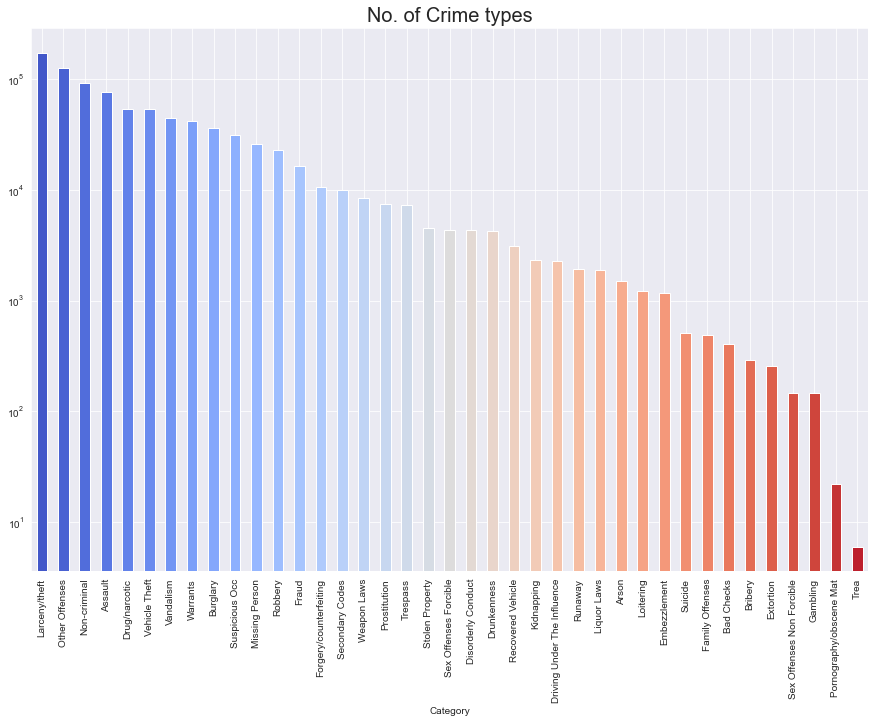

In [451]:
# 視覺化觀察犯罪類型排名
cat_num = len(cate_group.index)
cate_group.index = cate_group.index.map(string.capwords)
cate_group.sort_values(ascending=False,inplace=True)
cate_group.plot(kind='bar',logy=True,figsize=(15,10),color=sns.color_palette('coolwarm',cat_num))
plt.title('No. of Crime types',fontsize=20)
plt.show()

In [452]:
# 觀察一下犯罪類型的占比
top6 = list(cate_group.index[:6])
top15 = list(cate_group.index[:15])
total = sum(cate_group) # sum: 將list內的值加總

count = 0
for i in top5:
    count = cate_group[i] + count
print('TOP 6   犯罪類型的占比為: {:.2f}'.format((100 * count) / total) + " %")

count = 0
for i in top15:
    count = cate_group[i] + count
    
print('TOP 15  犯罪類型的占比為: {:.2f}'.format((100 * count) / total) + " %")

TOP 6   犯罪類型的占比為: 59.70 %
TOP 15  犯罪類型的占比為: 93.32 %


#### 2. PdDistrict 出警的警局名稱

In [453]:
# 一樣先判斷一下群體
dis_group = train.groupby('PdDistrict').size() 

# 犯罪類型數量
dis_group_num = len(dis_group.index)
print("出警的警局數量: " + str(cat_num))

dis_group

出警的警局數量: 39


PdDistrict
BAYVIEW        89431
CENTRAL        85460
INGLESIDE      78845
MISSION       119908
NORTHERN      105296
PARK           49313
RICHMOND       45209
SOUTHERN      157182
TARAVAL        65596
TENDERLOIN     81809
dtype: int64

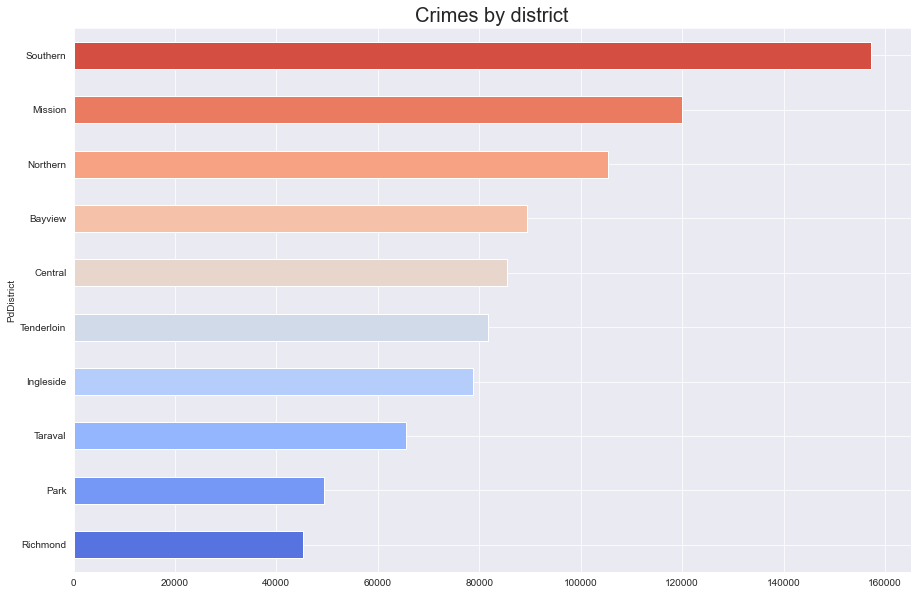

In [454]:
dis_group.index = dis_group.index.map(string.capwords)
dis_group.sort_values(ascending=True,inplace=True)
dis_group.plot(kind='barh',figsize=(15,10),color=sns.color_palette('coolwarm',dis_group_num))
plt.title('Crimes by district',fontsize=20)
plt.show()

#### 3. 犯罪事件時間

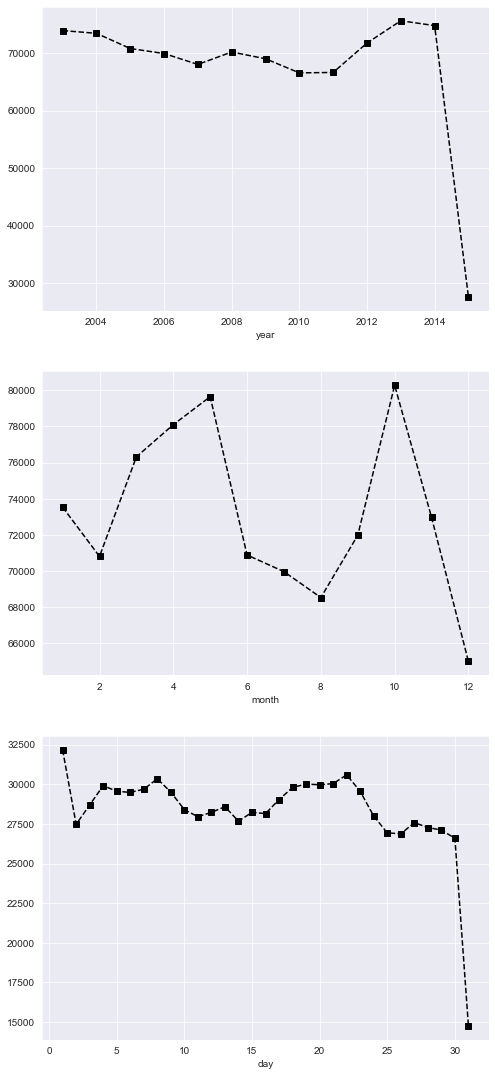

In [455]:
# 將 object 類型轉為 datetime 類型
train['date'] = pd.to_datetime(train['Dates'])

# 再將時間細分
train['year'] = train.date.dt.year
train['month'] = train.date.dt.month
train['day'] = train.date.dt.day
train['hour'] = train.date.dt.hour

# 看看各時間點的犯罪率
plt.figure(figsize=(8,19))

year_group = train.groupby('year').size()
plt.subplot(311)
plt.plot(year_group.index, year_group,'ks--')
plt.xlabel('year')

month_group = train.groupby('month').size()
plt.subplot(312)
plt.plot(month_group.index, month_group,'ks--')
plt.xlabel('month')

day_group = train.groupby('day').size()
plt.subplot(313)
plt.plot(day_group.index, day_group,'ks--')
plt.xlabel('day')

plt.show()

#### 4. Day of week

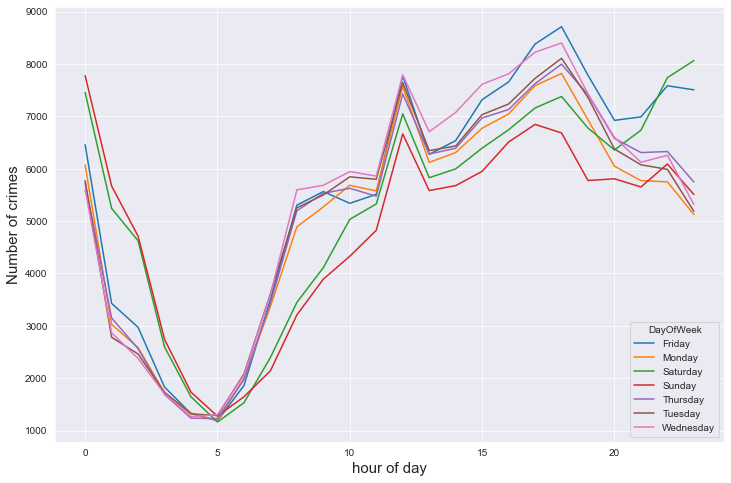

In [456]:
# 把一週跟小時組成一個群組
week_group = train.groupby(['DayOfWeek','hour']).size() # 取得一週內每天每小時的犯罪數量
week_group = week_group.unstack() # dataframe的旋轉操作 unstack：將資料的行“旋轉”為列

week_group.T.plot(figsize=(12,8))  # 行列互換後畫圖 , 可以直接用 group 畫圖 好看!
plt.xlabel('hour of day',size=15)
plt.ylabel('Number of crimes',size=15)
plt.show()

## 資料分析
- 對數量較多的前6種犯罪類型做分析：
    - hour v.s. Category
        - assault類案件在晚上6點後沒有下降趨勢 
    - PdDistrict v.s. Category
        - 犯罪率最高的Southern地區，偷竊類、暴力衝突類案件數量最多，車輛失竊類案件較少，猜測可能屬於貧困地區
        - 治安很好的地區Park,Richmond中，毒品、人身攻擊類案件比例明顯較少
    - month v.s. Category
        - 2-6月和8-12月是案件高发期，1-2月drug和other offense案发率较高。
- 高頻率犯罪的時間趨勢
    - 可見，不同種類的案件隨時間是有不同變化的，如vehicle theft在05年後急劇下降，可能法律有改，theft卻在12年後有升高的趨勢

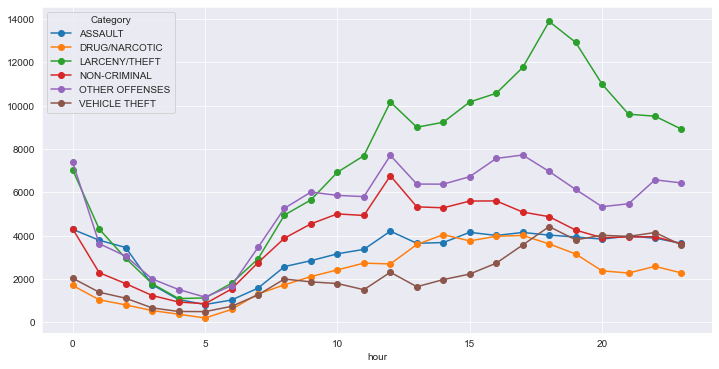

In [457]:
# hour v.s. 
tmp = train[train['Category'].map(string.capwords).isin(top6)] # 將前五類別做群體
tmp_group = tmp.groupby(['Category','hour']).size()
tmp_group = tmp_group.unstack()
tmp_group.T.plot(figsize=(12,6),style='o-')
plt.show()

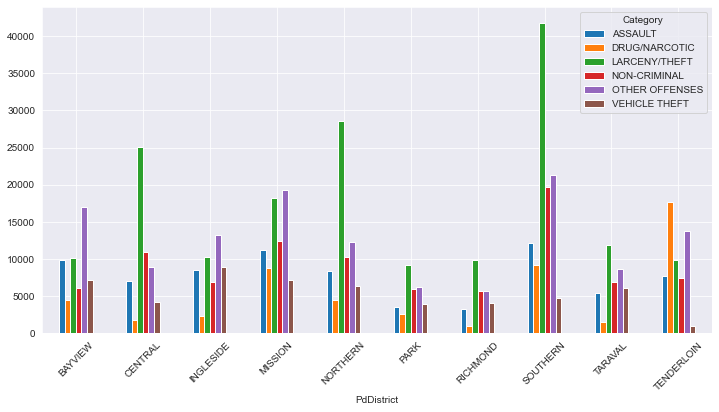

In [458]:
# PdDistrict v.s. Category
tmp2 = tmp.groupby(['Category','PdDistrict']).size()
tmp2.unstack().T.plot(kind='bar',figsize=(12,6),rot=45)
plt.show()

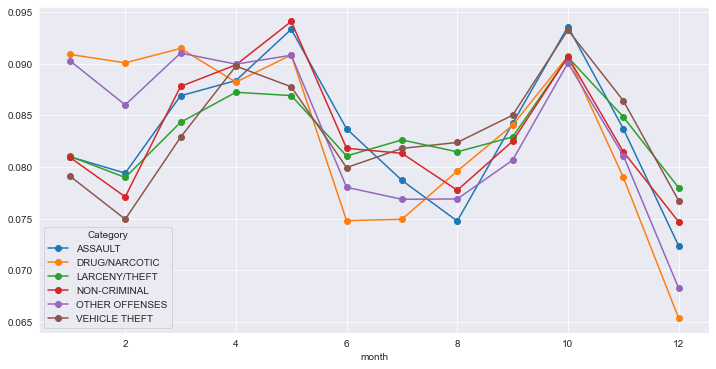

In [459]:
# mounth v.s. Category
mon_g = tmp.groupby(['Category','month']).size()
mon_g = mon_g.unstack()
for i in range(6):
    mon_g.iloc[i] = mon_g.iloc[i]/mon_g.sum(axis=1)[i]
mon_g.T.plot(figsize=(12,6),style='o-')
plt.show()

<AxesSubplot:xlabel='date'>

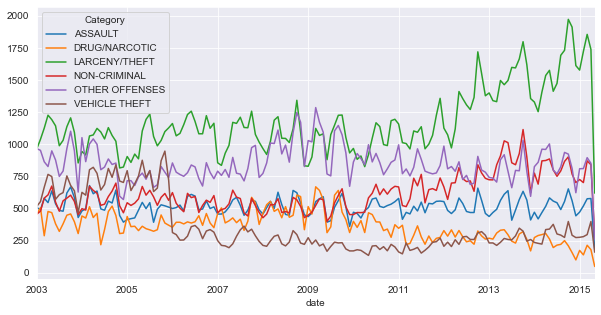

In [460]:
# 高案發時間趨勢
date_df = tmp.groupby(['Category',pd.Grouper('date')]).size()
date_df = date_df.unstack().fillna(0) # 缺值補 0
date_df = date_df.T # 將時間與類別 行列交換, 方便之後resample進行統計

# 按月求和
date_df_2 = date_df.resample('m').agg(sum) # 按照月份求和

date_df_2.plot(figsize=(10,5))

## 特徵工程
>1. 特徵建構: 從原始數據中人工的構建新的特徵，取代原始數據的特徵  
>2. 特徵提取: 將機器學習演算法不能識別的原始數據，轉化為演算法可以識別的特徵
    - 特徵提取的首要任務是將變數從文字轉換成數字，連續數值轉為離散數值，以利統計與導入演算法模型
>3. 特徵選擇: 從所有的特徵中選擇一組最好的特徵集，捨去無關的特徵，保留相關性高的特徵
    - 使用相關性作圖(Pearson相關係數)，顏色較淺的部分為沒有關係的，顏色偏藍就是正相關，顏色偏紅就是負相關，而我們在意的是與poi有相關性無論正負，若是值越接近0，即是要被剃除的特徵。

In [461]:
# 先對測試集做一樣的處理
test['date'] = pd.to_datetime(test['Dates'])
test['year'] = test.date.dt.year
test['month'] = test.date.dt.month
test['day'] = test.date.dt.day
test['hour'] = test.date.dt.hour
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Id          884262 non-null  int64         
 1   Dates       884262 non-null  object        
 2   DayOfWeek   884262 non-null  object        
 3   PdDistrict  884262 non-null  object        
 4   Address     884262 non-null  object        
 5   X           884262 non-null  float64       
 6   Y           884262 non-null  float64       
 7   date        884262 non-null  datetime64[ns]
 8   year        884262 non-null  int64         
 9   month       884262 non-null  int64         
 10  day         884262 non-null  int64         
 11  hour        884262 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 81.0+ MB


In [462]:
# 對分類目標做標籤化處理
label = preprocessing.LabelEncoder() # LabelEncoder :把每個類別 mapping 到某個整數，不會增加新欄位
target = label.fit_transform(train.Category) # 針對類別這個特徵做標籤編碼
target

array([37, 21, 21, ..., 16, 35, 12])

In [463]:
# 處理不統一的特徵
Id = test['Id']
des = train['Descript']
res = train['Resolution']
train.drop(['Category','Descript','Resolution'],axis=1,inplace=True) # 把用不到的特徵移除
test.drop('Id',axis=1,inplace=True) # 把用不到的特徵移除

# 合併數據方便處理 
full = pd.concat([train, test],keys=['train','test'])
full.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1762311 entries, ('train', 0) to ('test', 884261)
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Dates       object        
 1   DayOfWeek   object        
 2   PdDistrict  object        
 3   Address     object        
 4   X           float64       
 5   Y           float64       
 6   date        datetime64[ns]
 7   year        int64         
 8   month       int64         
 9   day         int64         
 10  hour        int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 195.3+ MB


In [464]:
full.head(5)

Dates  DayOfWeek PdDistrict                    Address  \
train 0  2015-05-13 23:53:00  Wednesday   NORTHERN         OAK ST / LAGUNA ST   
      1  2015-05-13 23:53:00  Wednesday   NORTHERN         OAK ST / LAGUNA ST   
      2  2015-05-13 23:33:00  Wednesday   NORTHERN  VANNESS AV / GREENWICH ST   
      3  2015-05-13 23:30:00  Wednesday   NORTHERN   1500 Block of LOMBARD ST   
      4  2015-05-13 23:30:00  Wednesday       PARK  100 Block of BRODERICK ST   

                  X          Y                date  year  month  day  hour  
train 0 -122.425892  37.774599 2015-05-13 23:53:00  2015      5   13    23  
      1 -122.425892  37.774599 2015-05-13 23:53:00  2015      5   13    23  
      2 -122.424363  37.800414 2015-05-13 23:33:00  2015      5   13    23  
      3 -122.426995  37.800873 2015-05-13 23:30:00  2015      5   13    23  
      4 -122.438738  37.771541 2015-05-13 23:30:00  2015      5   13    23

In [465]:
# 對 DayOfWeek 做 One hot encoding : 為每個類別新增一個欄位，用 0/1 表示是否
week = pd.get_dummies(full.DayOfWeek)

# PdDistrict 和 Address 意思重複
full.drop('Address', axis=1, inplace=True)
dist = pd.get_dummies(full.PdDistrict) # 針對地點也做 One hot encoding

#刪除重複的 Dates,date
full.drop(['Dates','date'],axis=1,inplace=True)

# 新增特徵
full['newy'] = full['month'].apply(lambda x:1 if x==1 or x==2 else 0)
full['dark'] = full['hour'].apply(lambda x:1 if x>=18 and x<=24 else 0)

# 年 月 小時 各做 One hot encoding
year_dum = pd.get_dummies(full.year)
month_dum = pd.get_dummies(full.month)
hour_dum = pd.get_dummies(full.hour)

# 删除、合併特徵
full.drop(['month','hour','day','year','DayOfWeek','PdDistrict'],axis=1,inplace=True)
full = pd.concat([full, week, dist, year_dum, month_dum, hour_dum, ],axis=1)

In [466]:
full.isnull().sum()

X             0
Y             0
newy          0
dark          0
Friday        0
Monday        0
Saturday      0
Sunday        0
Thursday      0
Tuesday       0
Wednesday     0
BAYVIEW       0
CENTRAL       0
INGLESIDE     0
MISSION       0
NORTHERN      0
PARK          0
RICHMOND      0
SOUTHERN      0
TARAVAL       0
TENDERLOIN    0
2003          0
2004          0
2005          0
2006          0
2007          0
2008          0
2009          0
2010          0
2011          0
2012          0
2013          0
2014          0
2015          0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0
10            0
11            0
12            0
0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0
10            0
11            0
12            0
13            0
14            0
15            0
16      

## 建立模型
- 建立需要用到的模型, 再利用交叉驗證判斷好壞

In [467]:
# 生成訓練集測試集

training,valid,y_train,y_valid = train_test_split(full[:train.shape[0]],target,train_size=0.7,random_state=0)

In [468]:
# 邏輯回歸

LR = LogisticRegression(C=0.1)
LR.fit(training, y_train)
predicted = np.array(LR.predict_proba(valid))
print("邏輯回歸 log 損失為 %f" %(log_loss(y_valid, predicted)))

邏輯回歸 log 損失為 2.638194


In [469]:
# # 隨機森林

# params = [20,22,24]
# for par in params:
#     clf = RandomForestClassifier(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
#                            max_features='sqrt', max_depth=par)

#     clf.fit(training, y_train)
#     predicted = np.array(clf.predict_proba(valid))
#     print("隨機森林log 損失為 %f" %(log_loss(y_valid, predicted)))

In [470]:
# 隨機森林

params = [28]
for par in params:
    clf = RandomForestClassifier(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=par)

    clf.fit(training, y_train)
    predicted = np.array(clf.predict_proba(valid))
    print("隨機森林log 損失為 %f" %(log_loss(y_valid, predicted)))

隨機森林log 損失為 2.414098


In [472]:
# 隨機森林

params = [30,32,34]
for par in params:
    clf = RandomForestClassifier(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=par)

    clf.fit(training, y_train)
    predicted = np.array(clf.predict_proba(valid))
    print("隨機森林log 損失為 %f" %(log_loss(y_valid, predicted)))

隨機森林log 損失為 2.412230
隨機森林log 損失為 2.412001
隨機森林log 損失為 2.411667


In [471]:
sub = pd.read_csv('./data/San Francisco Crime Classification/sampleSubmission.csv')
result = clf.predict_proba(full[train.shape[0]:])
submission = pd.DataFrame(result, columns=label.classes_)
submission['Id'] = sub['Id']
submission.to_csv('./data/San Francisco Crime Classification/submission.csv',index = False)